In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!gsutil cp gs://data-science-challenge-data/TestData.csv .

Copying gs://data-science-challenge-data/TestData.csv...
- [1 files][  2.8 MiB/  2.8 MiB]                                                
Operation completed over 1 objects/2.8 MiB.                                      


# Nikolay Ninov - Fourth Challenge

Before we dive into the coding part, the Jupyter notebook will be split in the following way:

1. **Exploratory Data Analysis** - this section will explore the provided dataset's features, ask and answer questions from the dataset. In this part the data itself will not be preprocessed unless it is required for visualization.

2. **Data Preprocessing** - this section will deal with preparing the dataset to be given to the model. Example problems that might occur are dealing with `NaN` values, curse of dimensionality, duplicates, scaling, etc.

3. **Machine Learning** - this section will take the preprocessed data from part 2, look into what would be the best way to measure the models' performance, insert different machine learning techniques and evaluate them.

In [ ]:
"""
Will be used to track UK holidays for the following reason:

Tip: In case you want to consider other factors influencing future sales, assume all locations are in London.
"""
!pip install --update holidays


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --update


In [ ]:
"""
This cell is used to import different libraries 
that will be used within the different sections
of the notebook.
"""

# Used in Exploratory Data Analysis and Data Preprocessing
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm # Used to calculate trend, seasonality, residual and observed
import random # Used to get a random location
import holidays # Check for holiday impact
from sklearn import preprocessing

# Used in the Machine Learning section
from sklearn import metrics # Used for evaluation
# Explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
# Regression algorithms
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
# Load the dataset
df = pd.read_csv('TestData.csv')

## Exploratory Data Analysis

This section will explore the provided dataset's features, ask and answer questions from the dataset. In this part the data itself will not be preprocessed unless it is required for visualization.

### Basic information

In this section we will have a quick look at the dataset - how many columns it has and overall information about it.

In [ ]:
# Load the head of the dataset to get an idea of the data
df.head()

location        date        sales
0      9708  2017-12-01  5371.933333
1      9708  2017-12-02  6789.400000
2      9708  2017-12-03  2437.080000
3      9708  2017-12-04  1395.700000
4      9708  2017-12-05  2020.300000

In [ ]:
# Get information about the data's column types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95667 entries, 0 to 95666
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  95667 non-null  int64  
 1   date      95667 non-null  object 
 2   sales     95667 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


Columns `location` and `sales` are `int64` and `float64` types but the date is an `object` rather than `datetime`. To corretly continue exploring the dataset `date` will be fixed.

In [ ]:
# Convert date object to datetime
df['date'] = pd.to_datetime(df['date'])

# Get updated information about the datas
print(f"{df.info()}\n")

"""
Double check if the date column has 
been modified one way or another
"""
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95667 entries, 0 to 95666
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   location  95667 non-null  int64         
 1   date      95667 non-null  datetime64[ns]
 2   sales     95667 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.2 MB
None



location       date        sales
0      9708 2017-12-01  5371.933333
1      9708 2017-12-02  6789.400000
2      9708 2017-12-03  2437.080000
3      9708 2017-12-04  1395.700000
4      9708 2017-12-05  2020.300000

There are no impacts on the `date` column.

In [ ]:
# Get the dataset's size
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

The dataset has 95667 rows and 3 columns.


### Missing data

In order for us to continue development we have to explore the missing data and if there are any connections. This will allow. us to make more accurate models and predictions.

In [ ]:
print(f"Missing data:\n\n{df.isna().sum()}")

Missing data:

location    0
date        0
sales       0
dtype: int64


The dataset is does not have any missing data and we do not have to worry about dealing filling initial `NaN` values.

### Data distribution

Before we start forming hypotheses about the dataset, we will inspect if there are any relationships between the variables.

#### Box plot
The boxplot will let us see the variability or dispersion of the data. It will give us information about how the values in the columns are distributed. We will be able to see if the data is symmetrical, how tight it is group and how it is skewed.

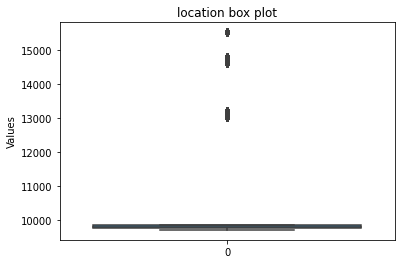

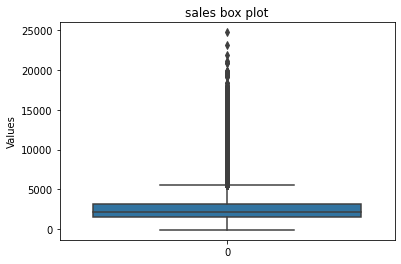

In [ ]:
types = ['int64', 'float64']

for type in types:
  for column in df.select_dtypes(include=[type]).columns:
    # Show box plot per column
    sns.boxplot(data = df[column])
    plt.title(f"{column} box plot")
    plt.ylabel(f"Values")
    plt.show()

    # Iteration separator
    print("=" * 48 + "\n")

The dataset shows that most of the locations are in one place (in the range from 0 to 10,000) and the rest are very far away from each other (from location 13,000 and above). However the location column does not give any information if the location ID means how close locations are to each other or it is just an ID number not related to the distance. The sales boxplot shows us how the sales are scaled if the numbers have to be scaled down. It seems that most of the sales are between 0 and 6,000 with outliers which go above 6,000

#### Scatter Matrix

A scatter matrix will allow us to plot all the numeric variables against each other.

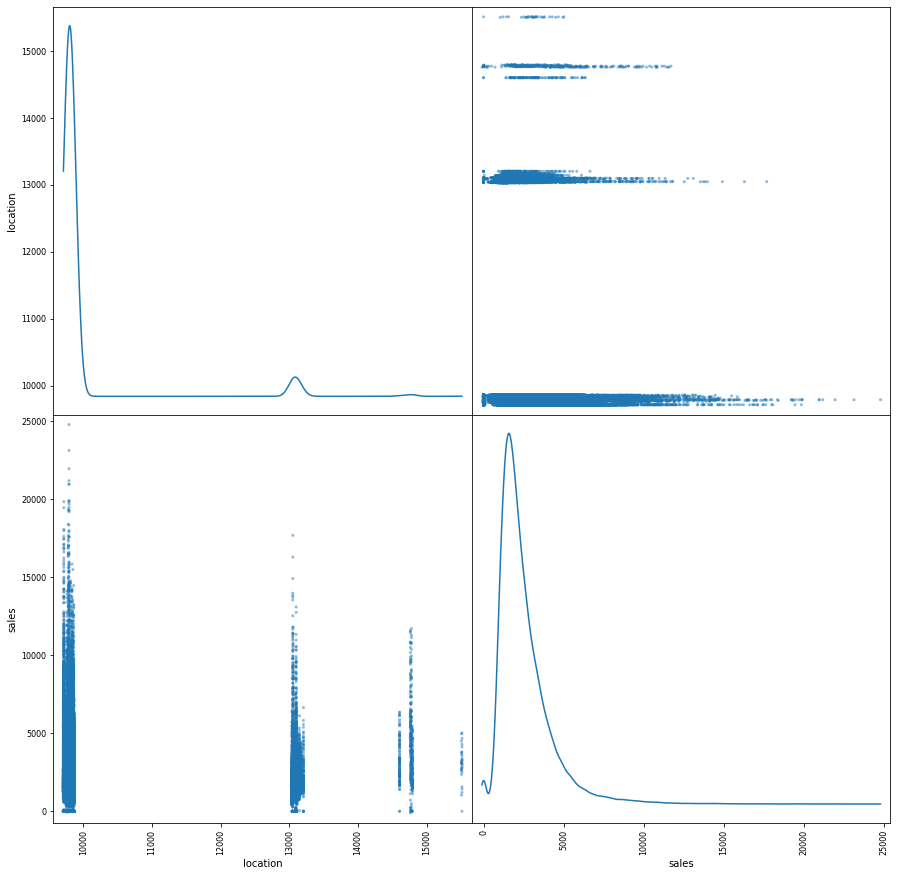

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(15, 15), diagonal = 'kde')
plt.show()

The matrix above shows that most of the sales have happened in stores that have a location ID number between 0 and 10,000. Location ID with a lower number has more sales than locations with a higher ID number.

However we do not know the sale's currency and we cannot make any assumptions if the sales are a lot or not. It is also unknown what the sales are on. For instance the sales can be on food, clothes, luxurious items, etc. 

### What is the dataset's timeframe?

Because there are not that many columns within the given dataset, it is useful to know the start and end point of it so we can form new ones.

In [ ]:
"""
Get first and last date, we will ignore 
the time because the dataset is on a 
daily basis rather than hourly
"""
# Get the minimum date (starting point) - only the date and ignore the hours
start = str(df['date'].min()).split(" ")[0]

# Get the maximum date (ending point) - only the date and ignore the hours
end = str(df['date'].max()).split(" ")[0]

# Get dataset's duration in days - get the days and ignore the hours
days = str(df['date'].max() - df['date'].min()).split(" ")[0]

print(f"The dataset is between {start} and {end}.\n")
print(f"The dataset consists of {days} days.")

The dataset is between 2017-12-01 and 2019-12-31.

The dataset consists of 760 days.


The dataset takes place between 01/12/2017 to 31/12/2019 which is 2 years and 1 month.

### Data Visualization

By visualizing the data we can form hypotheses and get a better insight from the data. This also allows us to start thinking about what kind of machine learning algorithms coulb be used to solve the forecasting problem. We will use `plotly.express` to get more details from the data visualization.

#### What is the sale performance of the dataset per location during the data's timeframe?

Let's try to understand how different locations are performing every day between 01/12/2017 and 31/12/2019. Some locations could have better performance than others.

In [ ]:
# Get total number of locations
total_locations = len(df['location'].unique())

fig = px.line(df, x="date", y="sales", color = "location", title = f"Sales per day for all {total_locations} locations")
fig.update_layout(hovermode = "x unified")
fig.show()

The above figure does not give any meaningful information and is unreadable because there are 163 locations in one diagram. The question above has to be rephrased. However let's further investigate what are the patterns are for the best and worst stores. As previously mentioned locations around 9,000 have more sales then locations above 10,000.

In [ ]:
# Find the best location
best_sales = df.groupby('location').sum().reset_index().copy()
best_sales = best_sales.loc[best_sales['sales'] == best_sales['sales'].max()]
best_location = best_sales['location'].values[0]
best_sales = df.loc[df['location'] == best_location].reset_index(drop = True)

# Find the worst location
worst_sales = df.groupby('location').sum().reset_index().copy()
worst_sales = worst_sales.loc[worst_sales['sales'] == worst_sales['sales'].min()]
worst_location = worst_sales['location'].values[0]
worst_sales = df.loc[df['location'] == worst_location].reset_index(drop = True)

# Show sales pattern for best and worst locations
fig = go.Figure()
fig.add_trace(go.Scatter(x = best_sales['date'], y = best_sales['sales'], name = f"Best location - {best_location}", mode="lines"))
fig.add_trace(go.Scatter(x = worst_sales['date'], y = worst_sales['sales'], name = f"Worst sales - {worst_location}", mode="lines"))
fig.update_layout(hovermode = "x unified", title = "Best and worst locations for sales")
fig.show()

It seems that the worst sales are due to the fact that the store opened very recently - on December 18th 2019. This raises the question if there are any other locations that have opened recently and have decreased sales as well.

#### What are the average sales per location?

As previously mentioned, it is very difficult to inspect the data based on price and date only. However we can try and see what is the average sales per location to get an overall idea of every location's performance between 01/12/2017 and 31/12/2019.

In [ ]:
"""
- Group the data by location and get the average per location.
- We reset_index() so the index counter (0, 1, 2, ..., n) is used instead of location. 
- We copy() the data so we get a fresh DataFrame instead of the initial data reference.
  This will not harm the dataset.
"""
mean_sales = df.groupby('location').mean().reset_index().copy()

fig = px.bar(mean_sales, x='location', y='sales', title = "Average sales per location")
fig.update_layout(hovermode = "x unified")
fig.show()

The locations are not sequential and have gaps between them. Instead of using `location` for the X axis, we can try and use `index` because it will not have any gaps like `location` does. We will put `location` on the hover option.

In [ ]:
# Make a new column that will be passed to the bar
mean_sales['index'] = mean_sales.index

fig = px.bar(mean_sales, x='index', y='sales', text='location', title = "Average sales per location")
fig.update_layout(hovermode = "x unified")
fig.show()

In [ ]:
# We finisehd using mean_sales and now we can delete it
del mean_sales

#### Are sales improving over time?

We will further investigate to see if the sales between 01/12/2017 and 31/12/2019 are increasing or decreasing. This will give us an overview of the locations' performance over time rather than looking at every location individually.

In [ ]:
"""
- Group the data by date and get the total sales per day.
- We reset_index() so the index counter (0, 1, 2, ..., n) is used instead of date. 
- We copy() the data so we get a fresh DataFrame instead of the initial data reference.
  This will not harm the dataset.
"""
daily_sales = df.groupby("date").sum()[['sales']].copy()
# Even though the index is date, we need a date column to visualize the sales per day
daily_sales['date'] = pd.to_datetime(daily_sales.index)

fig = px.line(daily_sales, x="date", y="sales", title = f"Sales per day per")
fig.update_layout(hovermode = "x unified")
fig.show()

From the diagram above we can see that there are a lot of spikes within the sales per day. It is not entirely clear what the trend is. We will take a 7 period for `seasonal_decompose` to see in which direction the trend is going per week.

In [ ]:
# Set the index as date for sm.tsa.seasonal_decompose
local_data = daily_sales.set_index('date')

# Get start date as a string
start = str(local_data.index.min()).split(" ")[0]
# Get end date as a string
end = str(local_data.index.max()).split(" ")[0]

# Get trend, seasonality, residual and observed of a 7 day period                  
decomposition = sm.tsa.seasonal_decompose(local_data['sales'], model = 'additive', period = 7)

# Create subplots for sales, trend, seasonal and residual
fig = make_subplots(rows = 4, cols = 1, shared_xaxes = True, subplot_titles = (f'Sales per day from {start} to {end}', 
                                                                              f'Trend from {start} to {end}', 
                                                                              f'Seasonal from {start} to {end}',
                                                                              f'Residual from {start} to {end}'))

fig.add_trace(go.Scatter(x = local_data.index, y = local_data['sales'], name = "Sales"),row = 1, col = 1)
fig.add_trace(go.Scatter(x = local_data.index, y = decomposition.trend, name = "Trend"),row = 2, col = 1)
fig.add_trace(go.Scatter(x = local_data.index, y = decomposition.seasonal, name = "Seasonal"),row = 3, col = 1)
fig.add_trace(go.Scatter(x = local_data.index, y = decomposition.resid, name = "Residual"),row = 4, col = 1)

fig.update_layout(hovermode = "x unified")
fig.show()

To get a better understanding of the trend, let's look at the Simple Moving Average for 7, 14 and 28 days. This will give us an insight what the average price is for 1, 2 and 4 weeks.

In [ ]:
# Add SMA - 7 days, 14 days, 28 days
daily_sales['SMA_7'] = daily_sales['sales'].rolling(7).mean()
daily_sales['SMA_14'] = daily_sales['sales'].rolling(14).mean()
daily_sales['SMA_28'] = daily_sales['sales'].rolling(28).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x = daily_sales['date'], y = daily_sales['SMA_7'], name = f"SMA 7", mode="lines"))
fig.add_trace(go.Scatter(x = daily_sales['date'], y = daily_sales['SMA_14'], name = f"SMA 14", mode="lines"))
fig.add_trace(go.Scatter(x = daily_sales['date'], y = daily_sales['SMA_28'], name = f"SMA 28", mode="lines"))

fig.update_layout(hovermode = "x unified", title = "Standard Moving Average Sales")
fig.show()

We can also use Moving Average Convergence Divergence (**MACD**) to get an idea of the trend. MACD is based on the differences between two moving averages of different lengths - Fast and Slow moving average. In the sales case the fast moving average will be 14 days and the slow moving average will be 28 days.

In [ ]:
ema_14 = daily_sales['sales'].ewm(span = 14).mean()
ema_28 = daily_sales['sales'].ewm(span = 28).mean()

daily_sales['MACD'] = ema_14 - ema_28
daily_sales['MACD_signal'] = daily_sales['MACD'].ewm(span = 9).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x = daily_sales['date'], y = daily_sales['MACD'], name = f"MACD", mode="lines"))
fig.add_trace(go.Scatter(x = daily_sales['date'], y = daily_sales['MACD_signal'], name = f"MACD Signal", mode="lines"))

fig.update_layout(hovermode = "x unified", title = "Moving Average Convergence Divergence (MACD)")
fig.show()

In [ ]:
# We finisehd using mean_sales and now we can delete it
del daily_sales, ema_14, ema_28

Overall the SMAs and MACD show that with time sales improve.

#### What the trend, seasonality and residual are for the data?

So far we have looked at the total sales. We tried to display sales for all locations on a single diagram and the end results were not clear. We will look into a decomposition based on a single location to get a better insight of individual location performance. We will use the a perod of 7 to detect weekly patterns. To speed up Colab's computation, we will randomly generate a location with `random.choice` instead of displaying all of the locations and their data.

In [ ]:
# Get decomposed data for random df['local']
def single_random_decompose(data):
  location = random.choice(data['location'].unique())

  # Get a copy of the dataframe
  local_data = data.copy()
  # Delete passed dataframe - not needed anymore
  del data

  # Set the index as date for sm.tsa.seasonal_decompose
  local_data = local_data.set_index('date')
  # Extract data only for randomised location
  local_data = local_data.loc[local_data['location'] == location].copy()

  # Get start date as a string
  start = str(local_data.index.min()).split(" ")[0]
  # Get end date as a string
  end = str(local_data.index.max()).split(" ")[0]

  # Get trend, seasonality, residual and observed of a 7 day period                  
  decomposition = sm.tsa.seasonal_decompose(local_data['sales'], model = 'additive', period = 7)

  # Create subplots for sales, trend, seasonal and residual
  fig = make_subplots(rows = 4, cols = 1, shared_xaxes = True, subplot_titles = (f'Sales per day from {start} to {end} for {location}', 
                                                                                f'Trend from {start} to {end} for {location}', 
                                                                                f'Seasonal from {start} to {end} for {location}',
                                                                                f'Residual from {start} to {end} for {location}'))

  fig.add_trace(go.Scatter(x = local_data.index, y = local_data['sales'], name = "Sales"),row = 1, col = 1)
  fig.add_trace(go.Scatter(x = local_data.index, y = decomposition.trend, name = "Trend"),row = 2, col = 1)
  fig.add_trace(go.Scatter(x = local_data.index, y = decomposition.seasonal, name = "Seasonal"),row = 3, col = 1)
  fig.add_trace(go.Scatter(x = local_data.index, y = decomposition.resid, name = "Residual"),row = 4, col = 1)

  fig.update_layout(hovermode = "x unified")
  fig.show()

  del local_data

In [ ]:
# Feel free to rerun this cell to see different locations' information
single_random_decompose(df)

As it was initially mentioned, not all locations could have the same start and end date. From randopmly going through locations with the code above the non-consisting start and end date format was noticed more and more. Let's further investigate this issue.

#### Do all locations have the same starting and end date?

There is a possibility that there are locations that do not have the exact same start and end date. This could cause further issues if we take into consideration dealing with `location` when designing the models in the upcoming sections.

In [ ]:
same_dates = df.copy()

locations = same_dates['location'].unique()

# Create a dataframe which will store the location, start date and end date
date_locations = pd.DataFrame(columns=['location', 'start_date', 'end_date'])

for location in locations:
  # Get starting date for current location
  start = same_dates.loc[same_dates['location'] == location, 'date'].min()
  # Get ending date for current location
  end = same_dates.loc[same_dates['location'] == location, 'date'].max()
  # Create row for dataframe
  temp = {
      "location": location,
      "start_date": start,
      "end_date": end
  }
  # Add current row to dataframe
  date_locations = date_locations.append(temp, ignore_index = True)

unique_starts = len(date_locations['start_date'].unique()) 
unique_ends = len(date_locations['end_date'].unique())

if unique_starts > 1:
  print(f"There are {unique_starts} different starting dates.\n")
else:
  print(f"There is one starting date - {date_locations['start_date'].unique()[0]}.\n")

if unique_ends > 1:
  print(f"There are {unique_ends} different ending dates.")
else:
  print(f"There is one ending date - {date_locations['end_date'].unique()[0]}.")

del date_locations, same_dates

There are 46 different starting dates.

There is one ending date - 2019-12-31T00:00:00.000000000.


It seems that the dataset has different starting dates but has only 1 ending date - 31/12/2019. This means that as time progresses sales could have increased because there were more available locations.

#### Did expanding new locations improve sales?

From the question above, we found it that there are 46 different starting location but all of the locations have the same end date - 31/12/2019. However with time sales could have increased because there are more stores.

In [ ]:
count_locations = df.copy()

# Create column that will store number of locations per day
count_locations['stores'] = 0

# Get how many open stores there are per day
for day in count_locations['date'].unique():
  stores = len(count_locations.loc[count_locations['date'] == day, 'location'].unique())
  count_locations.loc[count_locations['date'] == day, 'stores'] = stores

# Sort by date - the 'stores' column will be transferred to another dataframe
count_locations = count_locations.sort_values(by='date')

# Get sales per day
sales = count_locations.groupby('date').sum().reset_index().copy()
# Sort by date
sales = sales[['date', 'sales']].sort_values(by='date')
# Transfer store data to sales dataframe
sales['stores'] = count_locations['stores']

start = str(sales['date'].min()).split(" ")[0]
end = str(sales['date'].max()).split(" ")[0]

fig = px.bar(sales, x='date', y='sales', color='stores', title = f"Daily sales based on available locations from {start} to {end}")
fig.update_layout(hovermode = "x unified")
fig.show()

It seems that with time sales are increasing because there are more available locations, however there are some outliers. This might be due to holidays. **What can be noticed is that every December 26th the data is extremely low and then it continues normally.**

In [ ]:
fig = px.line(sales, x="date", y="stores", title = f"Open stores from {start} to {end}")
fig.update_layout(hovermode = "x unified")
fig.show()

#### Is there a sales impact due to holidays?

Holidays might lead to less sales which could be helpful when predicting the future. 

In [ ]:
uk_holidays = holidays.UnitedKingdom()

# Get holidays in dataframe
sales['holidays'] = sales['date'].apply(lambda day: day in uk_holidays)
sales['holiday_name'] = sales['date'].apply(lambda day: str(uk_holidays.get(day)))

print(f"Holidays:\n\n{sales['holiday_name'].unique()}")

Holidays:

['None' 'Boxing Day' "New Year's Day" 'New Year Holiday [Scotland]'
 "St. Patrick's Day [Northern Ireland]"
 "St. Patrick's Day [Northern Ireland] (Observed)" 'Good Friday'
 'Easter Monday [England/Wales/Northern Ireland]' 'May Day'
 'Spring Bank Holiday' 'Battle of the Boyne [Northern Ireland]'
 'Summer Bank Holiday [Scotland]'
 'Late Summer Bank Holiday [England/Wales/Northern Ireland]'
 "St. Andrew's Day [Scotland]"]


In [ ]:
data_holidays = sales.loc[sales['holidays'] == True].copy()

fig = px.line(sales, x="date", y="sales", title = f"Holiday sales from {start} to {end}")
fig.add_trace(go.Scatter(x = data_holidays['date'], y = data_holidays['sales'], name = "Holidays", mode="markers", text = data_holidays['holiday_name']))

fig.update_layout(hovermode = "x unified")
fig.show()

It seems that holidays can have an impact on sales when there are close to each other. Even though December 24th is not an official holiday a lot of people take is as a day off to meet family and friends. There is data missing for every **Christmas** because it is not a working day. **However sales are always lower on December 26th because it is a holiday.**

In [ ]:
sales['month'] = pd.DatetimeIndex(sales['date']).month 
sales['day'] = pd.DatetimeIndex(sales['date']).day 

around_christmas = sales.loc[np.logical_and(np.logical_or(sales['day'] == 24, sales['day'] == 26), sales['month'] == 12)]

fig = px.line(sales, x="date", y="sales", title = f"Holiday sales from {start} to {end}")
fig.add_trace(go.Scatter(x = data_holidays['date'], y = data_holidays['sales'], name = "Holidays", mode="markers", text = data_holidays['holiday_name']))
fig.add_trace(go.Scatter(x = around_christmas['date'], y = around_christmas['sales'], name = "Before / After Christmas", mode="markers"))

fig.update_layout(hovermode = "x unified")
fig.show()

Overall holidays have an impact on sales, depending on the holiday. However Christmas has a drop of sales for every year in the dataset.
<br>
<br>

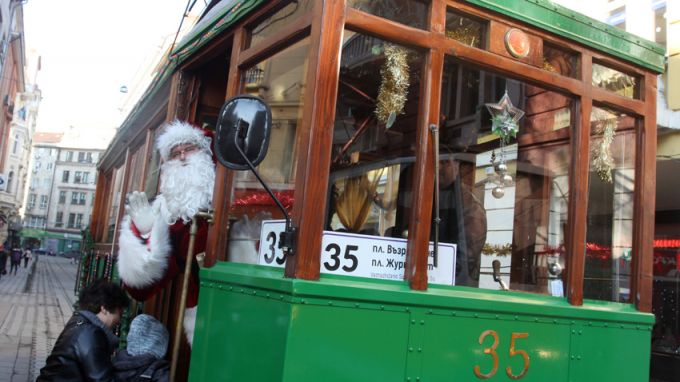

#### How many locations work on holidays?

As seen above, holidays have an impact on the data. Now we will investigate if there are less locations working on holidays.

In [ ]:
fig = px.line(sales, x="date", y="stores", title = f"Number of stores working during holidays {start} to {end}")
fig.add_trace(go.Scatter(x = data_holidays['date'], y = data_holidays['stores'], name = "Holidays", mode="markers", text = data_holidays['holiday_name']))
fig.add_trace(go.Scatter(x = around_christmas['date'], y = around_christmas['stores'], name = "Before / After Christmas", mode="markers"))

fig.update_layout(hovermode = "x unified")
fig.show()

There are no drops in working locations per day due to holidays.

In [ ]:
# Not needed anymore
del count_locations, data_holidays, around_christmas, sales

#### What are the is the busiest days of the week?

So far we have looked at patterns for the entire dataset but now we can go a little bit deeper - on a day of the week basis. We will investigate if there is a correlation between day of the week and sales.

In [ ]:
weekly_data = df.copy()
# Get day of the week
weekly_data['week_day'] = weekly_data['date'].dt.dayofweek

`dayofweek` maps the data in the following way:

```
0 - Monday
1 - Tuesday
2 - Wednesday
3 - Thursday
4 - Friday
5 - Saturday
6 - Sunday
```


In [ ]:
# Number to day mapping
mappings = {
    "0": "Monday",
    "1": "Tuesday",
    "2": "Wendesday",
    "3": "Thursday",
    "4": "Friday",
    "5": "Saturday",
    "6": "Sunday"
}

# Group by day of the week 
weekly_data = weekly_data.groupby("week_day").sum()
weekly_data['day'] = weekly_data.index

# Map the numbers to day of the week name
for day in weekly_data['day'].unique():
  weekly_data.loc[weekly_data['day'] == day, 'day'] = mappings[str(day)]

fig = px.pie(weekly_data, names='day', values='sales', title = "Sales per day of week", labels = {'day': 'day'})
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(hovermode = "x unified")

The data shows that the busiest period of the week is Friday and the weekend. There are most sells on Saturdays. Week days are steady because people go to work and have less time to purchase.

In [ ]:
# Not used anymore
del weekly_data

#### Are the Friday and Saturday patterns consistent?

So far we have established that Friday and Saturdays are the busiest periods of the week. However, we need to further investigate if this is consistent during the entire dataset or not.

In [ ]:
consistent_data = df.copy()

# Get the total sales per day
consistent_data = consistent_data.groupby('date').sum()['sales'].reset_index()
consistent_data = consistent_data.sort_values('date')

consistent_data['day'] = consistent_data['date'].dt.dayofweek

# Map the numbers to day of the week name
for day in consistent_data['day'].unique():
  consistent_data.loc[consistent_data['day'] == day, 'day'] = mappings[str(day)]

fig = px.bar(consistent_data, x='date', y='sales', color = 'day', title = "Sales per day of week")
fig.update_layout(hovermode = "x unified")
fig.show()

Most of the times the sales are consistent however there are some minor cases where **Friday** and **Saturday** are not the dominant sales days.

In [ ]:
# Not needed anymore
del consistent_data

## Data Preparation

This section will deal with preparing the dataset to be given to the model. Example problems that might occur are dealing with `NaN` values, curse of dimensionality, duplicates, scaling, etc.

In [ ]:
# The data that will be given to the models will be in a seperate variable
model_data = df.copy()

### Additional columns

The fundamental datset has only 3 columns - location, date and sales. So far we changed the date column from `object` to `datetime64`. Now we will look into adding extra columns to the dataset to help identify predicting patterns.

#### Day of the week

From the Exploratory Data Analysis we discovered that during the weekdays there are less sales compared to Friday and the weekend. Two features that can be added are - current day and next day. Although we cannot predict tomorrow's sales, we can predict which day is tomorrow without any issues.

In [ ]:
model_data['current_day'] = model_data['date'].dt.dayofweek

# Data so far
model_data.head(8)

location       date        sales  current_day
0      9708 2017-12-01  5371.933333            4
1      9708 2017-12-02  6789.400000            5
2      9708 2017-12-03  2437.080000            6
3      9708 2017-12-04  1395.700000            0
4      9708 2017-12-05  2020.300000            1
5      9708 2017-12-06  2246.533333            2
6      9708 2017-12-07  3401.200000            3
7      9708 2017-12-08  6707.233333            4

In [ ]:
# Last day will be NaN so we will add it manually
model_data['next_day'] = model_data['current_day'].shift(-1)
# Get last day before NaN
week_day = model_data.iloc[-1, model_data.columns.get_loc('current_day')]

# Check if it is not Sunday
if week_day < 6:
  model_data.iloc[-1, model_data.columns.get_loc('next_day')] = week_day + 1

# If it is Sunday then set to 0 (Monday)
else:
 model_data.iloc[-1, model_data.columns.get_loc('next_day')] = 0

model_data['next_day'] = model_data['next_day'].astype(int)

model_data.tail(6)

location       date        sales  current_day  next_day
95661     15512 2019-12-24  4287.466667            1         4
95662     15512 2019-12-27  3573.933333            4         5
95663     15512 2019-12-28  3800.466667            5         6
95664     15512 2019-12-29  3053.733333            6         0
95665     15512 2019-12-30  3295.133333            0         1
95666     15512 2019-12-31  3389.100000            1         2

#### Date

To help with pattern recognition, the `date` column will be split into 3 columns - `year`, `month` and `day`.

In [ ]:
model_data['year'] = pd.DatetimeIndex(model_data['date']).year 
model_data['month'] = pd.DatetimeIndex(model_data['date']).month 
model_data['day'] = pd.DatetimeIndex(model_data['date']).day 

model_data.head()

location       date        sales  current_day  next_day  year  month  day
0      9708 2017-12-01  5371.933333            4         5  2017     12    1
1      9708 2017-12-02  6789.400000            5         6  2017     12    2
2      9708 2017-12-03  2437.080000            6         0  2017     12    3
3      9708 2017-12-04  1395.700000            0         1  2017     12    4
4      9708 2017-12-05  2020.300000            1         2  2017     12    5

#### Holiday impact

As we saw in the Exploratory Data Analysis, holidays have an impact on sales, especially Christmas. We will add the holidays and the name of the holiday.

In [ ]:
start = model_data['date'].min()
end = model_data['date'].max()

# Get holidays in dataframe
uk_holidays = holidays.UnitedKingdom()
model_data['holidays'] = model_data['date'].apply(lambda day: day in uk_holidays)
model_data['holiday_name'] = model_data['date'].apply(lambda day: str(uk_holidays.get(day)))

# Show holidays
model_data.loc[model_data['holidays'] == True]

location       date         sales  current_day  next_day  year  month  \
29         9708 2018-01-01    868.313333            0         1  2018      1   
30         9708 2018-01-02   1404.700000            1         2  2018      1   
104        9708 2018-03-17   4655.413333            5         6  2018      3   
106        9708 2018-03-19    938.860000            0         1  2018      3   
117        9708 2018-03-30   5522.666667            4         5  2018      3   
...         ...        ...           ...          ...       ...   ...    ...   
95400     14768 2019-11-30   5811.233333            5         6  2019     11   
95488     14775 2019-11-30  10722.913333            5         6  2019     11   
95513     14775 2019-12-26   2579.373333            3         4  2019     12   
95551     14786 2019-11-30   4226.833333            5         6  2019     11   
95605     14793 2019-11-30   5076.860000            5         6  2019     11   

       day  holidays                                     holiday_name  
29       1      True                                   New Year's Day  
30       2      True                      New Year Holiday [Scotland]  
104     17      True             St. Patrick's Day [Northern Ireland]  
106     19      True  St. Patrick's Day [Northern Ireland] (Observed)  
117     30      True                                      Good Friday  
...    ...       ...                                              ...  
95400   30      True                      St. Andrew's Day [Scotland]  
95488   30      True                      St. Andrew's Day [Scotland]  
95513   26      True                                       Boxing Day  
95551   30      True                      St. Andrew's Day [Scotland]  
95605   30      True                      St. Andrew's Day [Scotland]  

[3036 rows x 10 columns]

#### Locations

As previously mentioned, the sales locations have increased and sales as well. We will use the total number of locations for that specific day as well. The more locations there are, the higher the sales are.



In [ ]:
# Create column that will store number of locations per day
model_data["stores"] = 0

for day in model_data['date'].unique():
  # Assign number of stores for that day based on how many unique locations generated sales on the day
  model_data.loc[model_data['date'] == day, 'stores'] = len(model_data.loc[model_data['date'] == day, 'location'].unique())

model_data.head()

location       date        sales  current_day  next_day  year  month  day  \
0      9708 2017-12-01  5371.933333            4         5  2017     12    1   
1      9708 2017-12-02  6789.400000            5         6  2017     12    2   
2      9708 2017-12-03  2437.080000            6         0  2017     12    3   
3      9708 2017-12-04  1395.700000            0         1  2017     12    4   
4      9708 2017-12-05  2020.300000            1         2  2017     12    5   

   holidays holiday_name  stores  
0     False         None     101  
1     False         None     101  
2     False         None     101  
3     False         None     101  
4     False         None     101

#### Lag

We will use the 1 day and 7 day lag The 1 day lag will tell us what the sales were for yesterday and the 7 day lag will tell us what the sales were the week before.

In [ ]:
model_data['lag_1'] = model_data['sales'].shift(1)
model_data['lag_7'] = model_data['sales'].shift(7)

model_data.head(10)

location       date        sales  current_day  next_day  year  month  day  \
0      9708 2017-12-01  5371.933333            4         5  2017     12    1   
1      9708 2017-12-02  6789.400000            5         6  2017     12    2   
2      9708 2017-12-03  2437.080000            6         0  2017     12    3   
3      9708 2017-12-04  1395.700000            0         1  2017     12    4   
4      9708 2017-12-05  2020.300000            1         2  2017     12    5   
5      9708 2017-12-06  2246.533333            2         3  2017     12    6   
6      9708 2017-12-07  3401.200000            3         4  2017     12    7   
7      9708 2017-12-08  6707.233333            4         5  2017     12    8   
8      9708 2017-12-09  8816.600000            5         6  2017     12    9   
9      9708 2017-12-10  1850.766667            6         0  2017     12   10   

   holidays holiday_name  stores        lag_1        lag_7  
0     False         None     101          NaN          NaN  
1     False         None     101  5371.933333          NaN  
2     False         None     101  6789.400000          NaN  
3     False         None     101  2437.080000          NaN  
4     False         None     101  1395.700000          NaN  
5     False         None     101  2020.300000          NaN  
6     False         None     101  2246.533333          NaN  
7     False         None     101  3401.200000  5371.933333  
8     False         None     101  6707.233333  6789.400000  
9     False         None     101  8816.600000  2437.080000

#### Seasonal decompose

When running seasonal decompose, we will not be able to run it on sales per day due to a large loss of data. However we can run it on the entire dataset to understand its pattern.

In [ ]:
decompose = sm.tsa.seasonal_decompose(model_data['sales'], model = 'additive', period = 7)

model_data['trend'] = decompose.trend
model_data['seasonal'] = decompose.seasonal

model_data.head(10)

location       date        sales  current_day  next_day  year  month  day  \
0      9708 2017-12-01  5371.933333            4         5  2017     12    1   
1      9708 2017-12-02  6789.400000            5         6  2017     12    2   
2      9708 2017-12-03  2437.080000            6         0  2017     12    3   
3      9708 2017-12-04  1395.700000            0         1  2017     12    4   
4      9708 2017-12-05  2020.300000            1         2  2017     12    5   
5      9708 2017-12-06  2246.533333            2         3  2017     12    6   
6      9708 2017-12-07  3401.200000            3         4  2017     12    7   
7      9708 2017-12-08  6707.233333            4         5  2017     12    8   
8      9708 2017-12-09  8816.600000            5         6  2017     12    9   
9      9708 2017-12-10  1850.766667            6         0  2017     12   10   

   holidays holiday_name  stores        lag_1        lag_7        trend  \
0     False         None     101          NaN          NaN          NaN   
1     False         None     101  5371.933333          NaN          NaN   
2     False         None     101  6789.400000          NaN          NaN   
3     False         None     101  2437.080000          NaN  3380.306667   
4     False         None     101  1395.700000          NaN  3571.063810   
5     False         None     101  2020.300000          NaN  3860.663810   
6     False         None     101  2246.533333          NaN  3776.904762   
7     False         None     101  3401.200000  5371.933333  3800.373333   
8     False         None     101  6707.233333  6789.400000  3799.299048   
9     False         None     101  8816.600000  2437.080000  3786.353333   

    seasonal  
0 -31.545265  
1 -32.937061  
2  -7.335772  
3   0.878057  
4  19.166012  
5  24.838523  
6  26.935505  
7 -31.545265  
8 -32.937061  
9  -7.335772

#### Simple Moving Averages and Moving Average Convergence Divergence

The more trend lines we have, the more different point of views  we give the models to work with. This will make detecting patterns easier. The SMA and MACD in the Exploratory Data Analysis are smoother than the sales per day. We will use smaller rolling windows for them so we can correctly capture the patterns.

In [ ]:
# Add SMA for 3, 6 and 12 days
model_data['SMA_3'] = model_data['sales'].rolling(3).mean()
model_data['SMA_6'] = model_data['sales'].rolling(6).mean()
model_data['SMA_12'] = model_data['sales'].rolling(12).mean()

# Add MADC
ema_6 = model_data['sales'].ewm(span = 6).mean()
ema_12 = model_data['sales'].ewm(span = 12).mean()

model_data['MACD'] = ema_6 - ema_12
model_data['MACD_signal'] = model_data['MACD'].ewm(span = 9).mean()

model_data.head()

location       date        sales  current_day  next_day  year  month  day  \
0      9708 2017-12-01  5371.933333            4         5  2017     12    1   
1      9708 2017-12-02  6789.400000            5         6  2017     12    2   
2      9708 2017-12-03  2437.080000            6         0  2017     12    3   
3      9708 2017-12-04  1395.700000            0         1  2017     12    4   
4      9708 2017-12-05  2020.300000            1         2  2017     12    5   

   holidays holiday_name  stores        lag_1  lag_7        trend   seasonal  \
0     False         None     101          NaN    NaN          NaN -31.545265   
1     False         None     101  5371.933333    NaN          NaN -32.937061   
2     False         None     101  6789.400000    NaN          NaN  -7.335772   
3     False         None     101  2437.080000    NaN  3380.306667   0.878057   
4     False         None     101  1395.700000    NaN  3571.063810  19.166012   

         SMA_3  SMA_6  SMA_12        MACD  MACD_signal  
0          NaN    NaN     NaN    0.000000     0.000000  
1          NaN    NaN     NaN   59.061111    32.811728  
2  4866.137778    NaN     NaN -186.838052   -57.208673  
3  3540.726667    NaN     NaN -347.572052  -155.570251  
4  1951.026667    NaN     NaN -355.037534  -214.907258

### Missing values

The initial dataset did not have any `NaN` values. However the new columns generated `NaN` values.

In [ ]:
# See all missing values
missing_data = model_data.loc[model_data.isnull().any(axis=1)]
print(f"There are {missing_data.shape[0]} missing rows.\n")

missing_data

There are 14 missing rows.



location       date        sales  current_day  next_day  year  month  \
0          9708 2017-12-01  5371.933333            4         5  2017     12   
1          9708 2017-12-02  6789.400000            5         6  2017     12   
2          9708 2017-12-03  2437.080000            6         0  2017     12   
3          9708 2017-12-04  1395.700000            0         1  2017     12   
4          9708 2017-12-05  2020.300000            1         2  2017     12   
5          9708 2017-12-06  2246.533333            2         3  2017     12   
6          9708 2017-12-07  3401.200000            3         4  2017     12   
7          9708 2017-12-08  6707.233333            4         5  2017     12   
8          9708 2017-12-09  8816.600000            5         6  2017     12   
9          9708 2017-12-10  1850.766667            6         0  2017     12   
10         9708 2017-12-11  1559.980000            0         1  2017     12   
95664     15512 2019-12-29  3053.733333            6         0  2019     12   
95665     15512 2019-12-30  3295.133333            0         1  2019     12   
95666     15512 2019-12-31  3389.100000            1         2  2019     12   

       day  holidays holiday_name  stores        lag_1        lag_7  \
0        1     False         None     101          NaN          NaN   
1        2     False         None     101  5371.933333          NaN   
2        3     False         None     101  6789.400000          NaN   
3        4     False         None     101  2437.080000          NaN   
4        5     False         None     101  1395.700000          NaN   
5        6     False         None     101  2020.300000          NaN   
6        7     False         None     101  2246.533333          NaN   
7        8     False         None     101  3401.200000  5371.933333   
8        9     False         None     101  6707.233333  6789.400000   
9       10     False         None     101  8816.600000  2437.080000   
10      11     False         None     102  1850.766667  1395.700000   
95664   29     False         None     163  3800.466667  4669.333333   
95665   30     False         None     163  3053.733333  5015.433333   
95666   31     False         None     163  3295.133333  2760.133333   

             trend   seasonal        SMA_3        SMA_6       SMA_12  \
0              NaN -31.545265          NaN          NaN          NaN   
1              NaN -32.937061          NaN          NaN          NaN   
2              NaN  -7.335772  4866.137778          NaN          NaN   
3      3380.306667   0.878057  3540.726667          NaN          NaN   
4      3571.063810  19.166012  1951.026667          NaN          NaN   
5      3860.663810  24.838523  1887.511111  3376.824444          NaN   
6      3776.904762  26.935505  2556.011111  3048.368889          NaN   
7      3800.373333 -31.545265  4118.322222  3034.674444          NaN   
8      3799.299048 -32.937061  6308.344444  4097.927778          NaN   
9      3786.353333  -7.335772  5791.533333  4173.772222          NaN   
10     3753.491429   0.878057  4075.782222  4097.052222          NaN   
95664          NaN  -7.335772  3476.044444  3453.188889  3363.219444   
95665          NaN   0.878057  3383.111111  3542.355556  3507.472222   
95666          NaN  19.166012  3245.988889  3566.638889  3580.600000   

             MACD  MACD_signal  
0        0.000000     0.000000  
1       59.061111    32.811728  
2     -186.838052   -57.208673  
3     -347.572052  -155.570251  
4     -355.037534  -214.907258  
5     -321.288802  -243.742571  
6     -180.489744  -227.734968  
7      230.488216  -117.615320  
8      672.024124    64.795309  
9      157.496595    85.565778  
10    -184.926118    26.383697  
95664   92.591418   163.325771  
95665   50.756514   140.811919  
95666   35.631835   119.775902

The missing data is in the columns that were manually created. Unfortunately the values cannot be replaced by mean, median or mode because it will be inconsistent. The missing data is only 30 rows and will not have an impact on the model's prediction.

In [ ]:
print(f"Data shape before:\t{model_data.shape}\n")
# Drop NaN rows
model_data = model_data.dropna(axis = 0)
model_data = model_data.reset_index(drop = True)
print(f"Data shape after:\t{model_data.shape}")

Data shape before:	(95667, 20)

Data shape after:	(95653, 20)


In [ ]:
# Not needed anymore
del missing_data

### Label Encoding

Row holidays tells us if the specific day is either a holiday (`True`) or not (`False`). We will use label encoding to change the `True` and `False` values to numbers. 

We do not know if location is not correlated with how far away the stores are from each other so it will not be encoded.

In [ ]:
le = preprocessing.LabelEncoder()
columns = ['holidays', 'holiday_name']

for column in columns:
  le.fit(model_data[column])
  model_data[column] = le.transform(model_data[column])

model_data.head()

location       date        sales  current_day  next_day  year  month  day  \
0      9708 2017-12-12  2012.780000            1         2  2017     12   12   
1      9708 2017-12-13  2155.913333            2         3  2017     12   13   
2      9708 2017-12-14  3171.166667            3         4  2017     12   14   
3      9708 2017-12-15  7074.366667            4         5  2017     12   15   
4      9708 2017-12-16  7146.693333            5         6  2017     12   16   

   holidays  holiday_name  stores        lag_1        lag_7        trend  \
0         0             8     101  1559.980000  2020.300000  3805.939048   
1         0             8     102  2012.780000  2246.533333  3567.380952   
2         0             8     102  2155.913333  3401.200000  3674.948571   
3         0             8     102  3171.166667  6707.233333  3748.956190   
4         0             8     102  7074.366667  8816.600000  3946.600952   

    seasonal        SMA_3        SMA_6       SMA_12        MACD  MACD_signal  
0  19.166012  1807.842222  4058.093333  3717.458889 -328.793971   -49.893571  
1  24.838523  1909.557778  3850.545556  3449.457222 -383.445496  -120.484746  
2  26.935505  2446.620000  3261.201111  3147.937778 -279.315676  -153.712295  
3 -31.545265  4133.815556  2970.828889  3534.378333  264.149109   -67.092346  
4 -32.937061  5797.408889  3853.483333  4013.627778  588.248874    67.771992

### Duplicates

Duplicates are non random data points which can cuase models to overfit. This means that the models could perform better on the training data rather than on the validation and test data.

In [ ]:
print(f"Data shape before:\t{model_data.shape}\n")
# Drop duplicates
model_data = model_data.drop_duplicates()
print(f"Data shape after:\t{model_data.shape}")

Data shape before:	(95653, 20)

Data shape after:	(95653, 20)


The data did not have any duplicates even before `drop_duplicates()` was used.

### Data split

#### Train / Validate / Test split

We will split the data into 3 parts - train (70%), validate (15%) and test(15%). We will use the train data to train the models, validate to check their performance and when we are comfortable in the the final results we will finally use the test one. We will split the data based on dates.

In [ ]:
dates = model_data['date'].unique()
# Sort dates in sequential order
dates.sort()

total = len(dates)
train_size = 0.7

# Get training date 
train_index = int(total * train_size)
train_date = dates[train_index]

train = model_data.loc[model_data['date'] <= train_date].reset_index(drop = True).copy()
print(f"Train:\t\t{train_date}\t{round(train_index / total, 2) * 100}%\n")

# Get validate date
half_remaining = int((total - int(total * train_size)) / 2)
validate_index = train_index + half_remaining
validate_date = dates[validate_index]

validate = model_data.loc[np.logical_and(model_data['date'] > train_date, model_data['date'] <= validate_date)].reset_index(drop = True).copy()
print(f"Validate:\t{validate_date}\t{round(validate_index / total, 2) * 100}%\n")

# Get test date
test_index = len(dates) - 1
test_date = dates[test_index]
test = model_data.loc[model_data['date'] > validate_date].reset_index(drop = True).copy()
print(f"Test:\t\t{test_date}\t{round(test_index / total, 2) * 100}%")

assert train.shape[0] + validate.shape[0] + test.shape[0] == model_data.shape[0], "Data split does not match with original data size. Data might have been lost..."

Train:		2019-05-17T00:00:00.000000000	70.0%

Validate:	2019-09-08T00:00:00.000000000	85.0%

Test:		2019-12-31T00:00:00.000000000	100.0%


In [ ]:
# Show train and test data
show_train = train.groupby('date').sum()["sales"].reset_index().copy()
show_validate = validate.groupby('date').sum()["sales"].reset_index().copy()
show_test = test.groupby('date').sum()["sales"].reset_index().copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x = show_train['date'], y = show_train['sales'], name = "Train", mode="lines"))
fig.add_trace(go.Scatter(x = show_validate['date'], y = show_validate['sales'], name = "Validate", mode="lines"))
fig.add_trace(go.Scatter(x = show_test['date'], y = show_test['sales'], name = "Test", mode="lines"))
fig.update_layout(hovermode = "x unified", title = "Train / Validate split")
fig.show()

del show_train, show_validate, show_test

#### Split data into `x` and `y`

Now we will split the train and validation data into x and y variables so it can be given to the models. The y variables are the column to be predicted - sales and everything else is in x variables.

In [ ]:
def split_data(data, y_column):
  """
  Function description

  Splits the data into X and Y

  parameters:
    - data - a dataframe with sales  (usually train / validate dataframe)
    - y_column - the column's name which will split the data into X and Y (in this dataset's case it is 'sales')

  output:
    - X data (all columns without sales)
    - Y data (sales column)
  """
  return data.drop(columns=[y_column], axis = 1).copy(), data[y_column].copy()

In [ ]:
train_x, train_y = split_data(train, 'sales')

validate_x, validate_y = split_data(validate, 'sales')

test_x, test_y = split_data(test, 'sales')

### Drop unnecessary columns

At this point the data is prepared to be given to the model, however we can drop the date column because it is not needed anymore. If we need to work with dates we can use the `int` values the date was split into (day, month and year).

In [ ]:
train_x = train_x.sort_values('date').reset_index(drop = True)
validate_x = validate_x.sort_values('date').reset_index(drop = True)
test_x = test_x.sort_values('date').reset_index(drop = True)

# Drop date column for train_x and validate_x
train_x = train_x.drop(columns=['date'], axis = 1)
validate_x = validate_x.drop(columns=['date'], axis = 1)
test_x = test_x.drop(columns=['date'], axis = 1)

## Machine Learning

This section takes the prepared data from section **Data Preparation** to look into what would be the best way to measure the models' performance, insert different machine learning techniques and evaluate them.

### Metrics

Before we get into model selection we will have to determine which metrics will be used to evaluate them. If the metrics are not good or consistent enough then the model's performance cannot be accurately measured. We will use the mean squared error (**MSE**) and mean absolute error (**MAE**).

MAE measures the average distance of the errors without considering the direction whereas MSE measures how close the fitted line is to the data points. The smaller MSE and MAE are, the close the predictions are to the data. The main metric that we will use is MSE and MAE will be used as a second best.

In [ ]:
def get_metrics(truth, prediction):
  """
  Function description

  Get MSE and MAE for the current model

  parameters:
    - truth - the ground truth of the values. In this case it would be the real sales from the dataset
    - prediction - the model's predicted values. In this case it would be the predicted sales from the dataset

  output:
    - MSE (mean squared error) 
    - MAE (mean absolute error)
  """
  mse = metrics.mean_squared_error(truth, prediction)
  mae = metrics.mean_absolute_error(truth, prediction)

  return mse, mae

In [ ]:
# Example run (not real)
get_metrics(train_y, train_y - 4)

(16.0, 4.0)

### Model selection

There are many different algorithms that can be used to solve the forecasting problem, however we need to find the most optimal ones. We will start off with looking at the basic algorithm, without any hyperparameter tuning. The aim is to quickly find a good starting point and continue investigating from there onwards. We will pick algorithms that have a better basic performance.

We will use the **KISS** technique - Keep It Simple Stupid. The dataset's size is very small and it does not have many features. To keep it simple stupid, we will use common regression algorithms that are used in basic machine learning regression problems.

In [ ]:
# Store algorithms in format - name: algorithm instance
algorithms = {
    "SVR": SVR(),
    "DecisionTree": DecisionTreeRegressor(), 
    "RandomForest": RandomForestRegressor(), 
    "GradientBoost": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(verbosity=0), # Ignore terminal output
    "LightGBM": LGBMRegressor()
}

# Store the the datasets within a dictionary
data = {
    "train_x": train_x,
    "train_y": train_y,
    "validate_x": validate_x,
    "validate_y": validate_y,
    "test_x": test_x,
    "test_y": test_y,
    "train": train,
    "validate": validate,
    "model_data": model_data
}

In [ ]:
def model_results(algorithms, data):
  """
  Function description

  Get the basic performance of the passed 
  algorithms on train and validation data

  parameters:
    - algorithms - all the algorithms in the above dictionary format
    - data - all the dataset in the above dictionary format
    
  output:
    - trained_algorithms - dictionary with the passed algorithms which were trained on the data
    - results - pandas dataframe with models' performance
  """

  results = pd.DataFrame()

  # Store trained algorithms
  trained_algorithms = {}

  for name, model in algorithms.items():
    
    model.fit(data["train_x"], data["train_y"])

    # Add fitted algorithm in dictionary
    trained_algorithms.update({name: model})

    # Predict train data
    predictions = model.predict(data["train_x"])
    mse_train, mae_train = get_metrics(data["train_y"], predictions)

    # Predict validation data
    predictions = model.predict(data["validate_x"])
    mse_validate, mae_validate = get_metrics(data["validate_y"], predictions)

    # Append row to pandas dataframe - results
    result = {}
    result['1. Algorithm'] = name
    result['2. MSE_train'] = mse_train
    result['3. MSE_validate'] = mse_validate
    result['4. MAE_train'] = mae_validate
    result['5. MAE_validate'] = mae_validate

    results = results.append(result, ignore_index = True)

    print(f"Completed - {name}")
  
  print("Finished training!")

  return trained_algorithms, results.round(2)

In [ ]:
trained_algorithms, results = model_results(algorithms, data)

Completed - SVR
Completed - DecisionTree
Completed - RandomForest
Completed - GradientBoost
Completed - XGBoost
Completed - LightGBM
Finished training!


In [ ]:
results.sort_values('3. MSE_validate')

1. Algorithm  2. MSE_train  3. MSE_validate  4. MAE_train  5. MAE_validate
4        XGBoost    2205603.90       2200603.26       1092.65          1092.65
3  GradientBoost    2199631.20       2214423.73       1097.43          1097.43
2   RandomForest     304007.06       2215546.30       1047.95          1047.95
0            SVR    2846048.44       2272144.69        997.66           997.66
5       LightGBM    1900822.95       2360240.95       1164.40          1164.40
1   DecisionTree          0.00       3625942.03       1408.28          1408.28

It seems that without any tuning, the `XGBoost`, `GradientBoost` and `RandomForest` have the best MSE score on the validation data.

Before we investigate the above mentioned algorithms, let's have a look at which features the algorithms find important. This will give us an insight which features are useful overall for which algorithms.

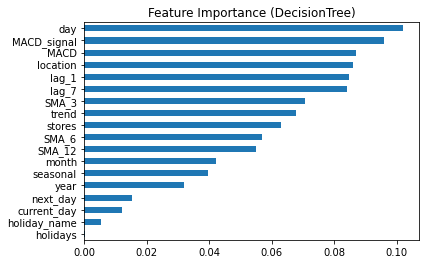

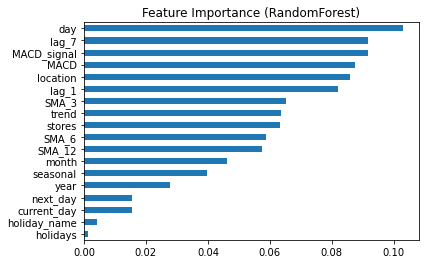

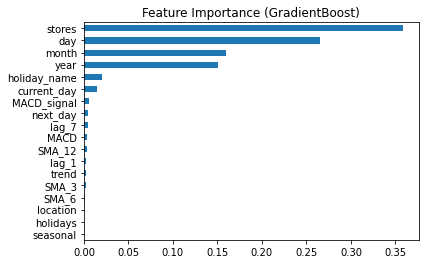

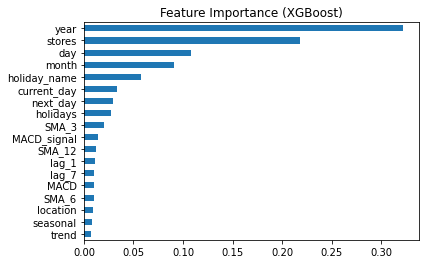

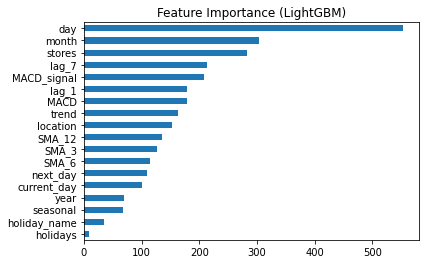

In [ ]:
# SVR does not have feature_importances_
for name in results['1. Algorithm'][1:]:
  # Create pandas dataframe with feature importances for every column
  feature_importance = pd.Series(trained_algorithms[f"{name}"].feature_importances_, index = train_x.columns)
  # Sort values
  feature_importance = feature_importance.sort_values()
  # Show bar plot of importance
  feature_importance.plot(kind="barh", title=f"Feature Importance ({name})")
  plt.show()

In [ ]:
def plot_predictions(algorithms, data):
  """
  Function description

  Plot the true validation sales and the predicted sales
  to determine the model's performance. The data is grouped
  by day.

  parameters:
    - algorithms - all the algorithms in the above dictionary format
    - data - all the dataset in the above dictionary format
    
  output:
    - no output
  """

  fig = make_subplots(rows = len(algorithms), cols = 1)
  row = 0
  colours = ['Red', 'Pink', 'Purple', 'Orange', 'Gray', 'Black']

  for name, model in algorithms.items():
    # Get train and validate data copies
    temp = data['model_data'].copy()
    temp = temp.groupby('date').sum()['sales'].reset_index()
    
    temp_validate = data['validate'].copy()

    # Get predictions for validation data
    temp_validate['predictions'] = model.predict(data['validate_x'])
    # Get daily sales for all stores
    temp_validate = temp_validate.groupby('date').sum()[['sales', 'predictions']].reset_index()

    # Show all real sales
    fig.add_trace(go.Scatter(x = temp_validate['date'], 
                             y = temp_validate['sales'], 
                             name = "Truth",
                             marker_color='LightSkyBlue'),
                  row = row + 1, col = 1)
    
    # Show predicted sales
    fig.add_trace(go.Scatter(x = temp_validate['date'], 
                             y = temp_validate['predictions'], 
                             name = f"{name} prediction",
                             marker_color = colours[row]),
                  row = row + 1, col = 1)
    row += 1
  
  fig.update_layout(hovermode = "x unified", title = "Prediction results")
  fig.show()

  # Not needed anymore
  del temp, temp_validate

In [ ]:
plot_predictions(trained_algorithms, data)

### Ensemble Voting

So far we have compared the algorithms individually but if they are combined they could give a better prediction. Even though **SVR** did not perform as well as the other algorithms, we will include it in the ensemble voting.

In [ ]:
"""
We will use VotingRegressor from sklearn.ensemble
but we need to make the algorithms in the correct input format:

[('algorithn name 1', algorithm 1),('algorithn name 2', algorithm 2), ..., ('algorithn name n', algorithm n)]
"""
voting_algorithms = list(algorithms.items())

ensemble = VotingRegressor(voting_algorithms)

In [ ]:
"""
To save time we will train the ensemble model by itself 
and append the return values to trained_algorithms and results
"""
trained_ensemble, ensemble_result = model_results({"VotingRegressor1": ensemble}, data)

Completed - VotingRegressor1
Finished training!


In [ ]:
new_results = results.copy()
new_results = new_results.append(ensemble_result, ignore_index = True)

new_results.sort_values('3. MSE_validate')

1. Algorithm  2. MSE_train  3. MSE_validate  4. MAE_train  \
6  VotingRegressor1    1133677.20       2172073.94       1051.64   
4           XGBoost    2205603.90       2200603.26       1092.65   
3     GradientBoost    2199631.20       2214423.73       1097.43   
2      RandomForest     304007.06       2215546.30       1047.95   
0               SVR    2846048.44       2272144.69        997.66   
5          LightGBM    1900822.95       2360240.95       1164.40   
1      DecisionTree          0.00       3625942.03       1408.28   

   5. MAE_validate  
6          1051.64  
4          1092.65  
3          1097.43  
2          1047.95  
0           997.66  
5          1164.40  
1          1408.28

The ensemble method has the best performance. However its performance could be improved if `DecisionTree` is removed. `DecisionTree` has the poorest performance and will drag down the ensemble. Let's try to rerun the above algorithm again but without `DecisionTree` to see if the performance has increased.

In [ ]:
new_voting_algorithms = algorithms.copy()
# Remove SVR from the dictionary
new_voting_algorithms.pop("DecisionTree")

# Create new ensemble without SVR
new_voting_algorithms = list(new_voting_algorithms.items())
ensemble = VotingRegressor(new_voting_algorithms)

# Get trained algorithms and results
trained_ensemble, ensemble_result = model_results({"VotingRegressor2": ensemble}, data)

Completed - VotingRegressor2
Finished training!


In [ ]:
new_results = new_results.append(ensemble_result, ignore_index = True)

new_results.sort_values('3. MSE_validate')

1. Algorithm  2. MSE_train  3. MSE_validate  4. MAE_train  \
7  VotingRegressor2    1631361.83       2128667.90       1044.13   
6  VotingRegressor1    1133677.20       2172073.94       1051.64   
4           XGBoost    2205603.90       2200603.26       1092.65   
3     GradientBoost    2199631.20       2214423.73       1097.43   
2      RandomForest     304007.06       2215546.30       1047.95   
0               SVR    2846048.44       2272144.69        997.66   
5          LightGBM    1900822.95       2360240.95       1164.40   
1      DecisionTree          0.00       3625942.03       1408.28   

   5. MAE_validate  
7          1044.13  
6          1051.64  
4          1092.65  
3          1097.43  
2          1047.95  
0           997.66  
5          1164.40  
1          1408.28

It seems that even after removing `DecisionTree` from the ensemble `VotingRegressor1`, `VotingRegressor2` became the best performing algorithm from all of the others.

### Hyperparameter tuning

As the results show above, the ensemble method performs the best out of all the algorithms. The algorithms that we will take into consideration are - `XGBoost`, `GradientBoost` and `RandomForest`. These are the three top performing algorithms and we will discard the rest. We would use `SVR` and `LightGBM` if we did not have a time limit. 

In order to save time we will use `HalvingGridSearch` rather than the traditional `GridSearch`. Instead. of performing the training on the entire data, training is performed on a subset. The aim is to evaluate all candidates with a small amount of resources and iteratively select the best candidates by usinig more and more resources.

In [ ]:
config = {
    "RandomForest": {
        "model": RandomForestRegressor(),
        "parameters": {
            'n_estimators': [100, 1050, 2000],
            'max_depth': [None, 10, 60, 110],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True]
        }
    },
    "GradientBoost": {
        "model": GradientBoostingRegressor(),
        "parameters": {
            'n_estimators': [500, 1000, 2000],
            'learning_rate': [.001,0.01,.1],
            'subsample': [.5,.75,1],
            'max_depth': [1, 2, 4],
            'random_state': [42]
        }
    },
    "XGBRegressor": {
        "model": XGBRegressor(),
        "parameters": {
            'n_estimators': range(50, 250, 50),
            'learning_rate': [0.05, 0.1, 0.3],
            'max_depth': range(1, 15, 2),
            'colsample_bytree': [0.8, 1.0, 1.2],
            'gamma': [0, 0.5, 1, 1.5],
            'random_state': [42],
            "n_jobs": [-1],
            'verbosity': [0] # Ignore terminal output
        }
    }
}

In [ ]:
def hyperparameter_tuning(config, data):
  """
  Function description

  Perform hyperparameter tuning on the provided models

  parameters:
    - config - all the algorithms that will be tuned in the above dictionary format
    - data - all the dataset in the above dictionary format
    
  output:
    - hyperparameters - dictionary with the best parameters
  """

  hyperparameters = {}
  resources = int(data['train_x'].shape[0])

  for name, model_config in config.items():
    # Extract model and parameters got HalvingGridSearchCV
    current_model = model_config["model"]
    current_parameters = model_config["parameters"]
    
    # Find best performing hyperparameters
    cv = HalvingGridSearchCV(current_model, current_parameters, n_jobs = -1, max_resources = resources, error_score='raise')
    cv.fit(data['train_x'], data['train_y'])

    print(f"Model:\t\t{name}")
    print(f"Best parameters:\t{cv.best_params_}")
    print(f"Best validation score:\t{cv.best_score_}\n")
    
    # Save the best parameters
    hyperparameters[name] = cv.best_params_

  print("Finished executing...")

  return hyperparameters

In [ ]:
# Takes very long to compute
# hyperparameters = hyperparameter_tuning(config, data)

After the hyperparameters were found we can now make an ensemble method.

In [ ]:
tuned_algorithms = {
    "XGBoost": XGBRegressor(learning_rate = 0.1, max_depth = 15, n_estimators = 500, random_state = 42),
    "RandomForest": RandomForestRegressor(n_estimators = 1050, max_depth = 60, min_samples_split = 2, min_samples_leaf = 4), 
    "GradientBoost": GradientBoostingRegressor(learning_rate = 0.001, max_depth = 4, n_estimators = 4, random_state = 42, subsample = 0.5)
}

tuned_voting = list(algorithms.items())
tuned_ensemble = VotingRegressor(tuned_voting)

tuned_trained_ensemble, tuned_ensemble_result = model_results({"TunedVotingRegressor": tuned_ensemble}, data)

Completed - TunedVotingRegressor
Finished training!


In [ ]:
new_results = new_results.append(tuned_ensemble_result, ignore_index = True)
new_results.sort_values('3. MSE_validate')

1. Algorithm  2. MSE_train  3. MSE_validate  4. MAE_train  \
7      VotingRegressor2    1631361.83       2128667.90       1044.13   
8  TunedVotingRegressor    1133473.92       2166706.46       1051.17   
6      VotingRegressor1    1133677.20       2172073.94       1051.64   
4               XGBoost    2205603.90       2200603.26       1092.65   
3         GradientBoost    2199631.20       2214423.73       1097.43   
2          RandomForest     304007.06       2215546.30       1047.95   
0                   SVR    2846048.44       2272144.69        997.66   
5              LightGBM    1900822.95       2360240.95       1164.40   
1          DecisionTree          0.00       3625942.03       1408.28   

   5. MAE_validate  
7          1044.13  
8          1051.17  
6          1051.64  
4          1092.65  
3          1097.43  
2          1047.95  
0           997.66  
5          1164.40  
1          1408.28

In [ ]:
plot_predictions(tuned_trained_ensemble, data)

It seems that even after hyperparameter tuning and using an ensemble method, the algorithms could not correctly identify the patterns

### 7 day prediction

This section will cover the final task that we have - provide daily sales for the next 7 days in the following format:

| location | Date of Prediction | Forecast day 1 | Forecast day 2 | Forecast day 3 | …   | Forecast day 7 |
|----------|--------------------|----------------|----------------|----------------|-----|----------------|
| 9809     | 2019-12-01         | 500            | 530            | 480            | ... | 830            |
| 9810     | 2019-12-01         | 1250           | 1300           | 600            | ... | 1670           |

Because our model's predictions are not accurate, we will use the validation data.

In [ ]:
def forecast(model, data):
  local_data = data['validate_x'].copy()

  # Sort the data by date
  local_data['date'] = pd.to_datetime(local_data['year'].astype(str) + "-" + local_data['month'].astype(str) + "-" + local_data['day'].astype(str))
  local_data = local_data.sort_values('date').reset_index(drop = True)

  # Will store results
  results = pd.DataFrame()

  # Go through every index
  for index in range(len(local_data)):
    # Get data in current row
    row = local_data.iloc[index]

    # Check if last 7 days of dataset are remaining
    if row['year'] == local_data.iloc[-1]['year'] and row['month'] == local_data.iloc[-1]['month'] and row['day'] == local_data.iloc[-1]['day'] - 7:
      break
    # Can forecast the days
    else:
      # Create location and date of prediction row
      result = {
          "location": row['location'],
          "Date of Prediction": pd.to_datetime(row['year'].astype(str) + "-" + row['month'].astype(str) + "-" + row['day'].astype(str))
      }

      start_date = result["Date of Prediction"]
      end_date = start_date + pd.DateOffset(days=7)

      # Get data for current location for next 7 days
      days = np.logical_and(local_data['date'] >= start_date, local_data['date'] < end_date)
      location = local_data['location'] == row['location']
      next_7_days = local_data.loc[np.logical_and(days, location)]
      
      # Prepare data to be given to the model
      next_7_days = next_7_days.drop(columns=['date'], axis=1)

      # Get predictions for 7 days
      next_7_days['predictions'] = model.predict(next_7_days)
      next_7_days = next_7_days.reset_index(drop = True)
      
      # Create forecasting rows - 1 to 7
      for day in range(len(next_7_days)):
        result[f"Forecast day {day + 1}"] = next_7_days.iloc[day]['predictions']

      results = results.append(result, ignore_index = True)

  results['location'] = results['location'].astype(int)
  return results

In [ ]:
results = forecast(tuned_trained_ensemble['TunedVotingRegressor'], data)

In [ ]:
results.head(5)

location Date of Prediction  Forecast day 1  Forecast day 2  \
0      9708         2019-05-18     2097.502681     2180.396503   
1      9848         2019-05-18     2507.907893     2109.348291   
2      9772         2019-05-18     1878.767300     2132.295279   
3      9833         2019-05-18     2404.294998     2475.033647   
4      9770         2019-05-18     2052.824381     2395.772719   

   Forecast day 3  Forecast day 4  Forecast day 5  Forecast day 6  \
0     2427.599539     2055.688627     2419.990390     2583.376844   
1     2273.891643     2195.003876     2235.409717     2380.118811   
2     2312.834740     2210.009806     2253.225608     1968.514569   
3     2447.395952     2518.324916     2566.913495     2432.376807   
4     2264.764178     2375.524687     2343.347060     2717.410287   

   Forecast day 7  
0     2453.292014  
1     1978.779954  
2     2410.395255  
3     2546.618157  
4     2036.898446

## Further work

Overall this notebook explores the provided sales forecasting dataset by asking questions that can further help us understand it and then we use machine learning on the data to predict sales. Further research can be done for other forecasting methods. Currently only traditional machine learning techniques were used, however we can also further investigate [Prophet](https://facebook.github.io/prophet/docs/quick_start.html), [AR](https://vitalflux.com/autoregressive-ar-models-with-python-examples/), [ARIMA](https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7), [SARIMA](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/), etc.




